# DenoiSeg Example: Mouse Organoid Cell
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a membrane labeled Mouse Organoid dataset from our collaborators. We already split the data into 86 train and 22 validation volumes. We will train a model on pathes of size 32x64x64 and we will do prediction on the validation set using original image size of 32x128x128.

# Define parameters

In [1]:
random_seed = 1000

# Values: 0.0 (no annotated images) to total number of training images (all images have annotations)
number_of_annotated_training_images = 7

# We added artificial noise to the data to make it more challenging to segment and to showcase the 
# denoising capabilities of the model. Here you can choose two presaved levels, n10 or n20 
noise_level = 'n20'

train_batch_size = 4

model_name = 'DenoiSeg_Mouse_Organoid_3D'
basedir = 'models'

In [2]:
# Here we are just importing some libraries that are needed to run this notebook.
import warnings
warnings.filterwarnings('ignore')

import os
import math
import urllib
import zipfile
import tifffile
from pathlib import Path
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data, add_noise, split_train_test_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision
from denoiseg.utils.denoiseg_data_preprocessing import generate_patches_from_list

from csbdeep.utils import plot_history

# Downloading and preparing data
In the next cells you download training dataset with the level of noise defined by `noise_level` parameter.

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

if noise_level == 'n10':
    link = 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n10.zip'
elif noise_level == 'n20':
    link = 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n20.zip'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath = 'data/Mouse-Organoid-Cells-CBG-128_{}.zip'.format(noise_level)
if not os.path.exists(zipPath):
    data = urllib.request.urlretrieve(link, zipPath)

#unzip the files
if not os.path.exists(zipPath[:-4]):
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

In [4]:
train = np.load(os.path.join(zipPath[:-8], 'train_data_{}.npz'.format(noise_level)))
val = np.load(os.path.join(zipPath[:-8], 'test_data_{}.npz'.format(noise_level)))

c = 10
X, Y = train['X_train'][:c, ...], train['Y_train'][:c, ...]
X_val, Y_val = val['X_test'][:c, ...], val['Y_test'][:c, ...]

print("Shape of Train volume:      {}".format(X.shape))
print("Shape of Train mask:        {}".format(Y.shape))
print("Shape of Validation volume: {}".format(X_val.shape))
print("Shape of Validation mask:   {}".format(Y_val.shape))

Shape of Train volume:      (10, 32, 128, 128)
Shape of Train mask:        (10, 32, 128, 128)
Shape of Validation volume: (10, 32, 128, 128)
Shape of Validation mask:   (10, 32, 128, 128)


In [5]:
percentage_of_annotated_training_images = float((number_of_annotated_training_images/X.shape[0])*100.0)
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

# Here we zero out all training images which are not part of the
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X, Y, fraction=percentage_of_annotated_training_images)

# Here we generate patches from images and apply augmentation
# augmentation will increase the number of images by the factor of 8, adding flips and 90 degree rotations. 
# One-hot encoding may take a couple of minutes.
axes = 'SZYX'
X_final, Y_final = generate_patches_from_list([X_frac], [Y_frac], axes, augment=True, shuffle=False, shape=(32, 64, 64))
X_val_final, Y_val_final = generate_patches_from_list([X_val], [Y_val], axes, augment=False, shape=(32, 64, 64))

X_final = X_final[... ,np.newaxis]
Y_final = convert_to_oneHot(Y_final, n_classes=3)

X_val_final = X_val_final[... ,np.newaxis]
Y_val_final = convert_to_oneHot(Y_val_final, n_classes=3)

print("Shape of Train volume:      {}".format(X_final.shape))
print("Shape of Train mask:        {}".format(Y_final.shape))
print("Shape of Validation volume: {}".format(X_val_final.shape))
print("Shape of Validation mask:   {}".format(Y_val_final.shape))

Shape of Train volume:      (320, 32, 64, 64, 1)
Shape of Train mask:        (320, 32, 64, 64, 3)
Shape of Validation volume: (40, 32, 64, 64, 1)
Shape of Validation mask:   (40, 32, 64, 64, 3)


## 3D visualization[optional]
For 3D visualization to be representative we resize the volume according to dataset's voxel(ZYX) size of [1.0, 0.1733, 0.1733] um. You may want to adjust the brighness level

In [6]:
import sys
!{sys.executable} -m pip install itkwidgets

     |████████████████████████████████| 3.4 MB 150 kB/s eta 0:00:011
     |████████████████████████████████| 58.8 MB 168 kB/s eta 0:00:012
     |████████████████████████████████| 271 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.5 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 73.6 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 81.1 MB 158 kB/s eta 0:00:012
     |████████████████████████████████| 510 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 11.2 MB/s eta 0:00:01
  Using cached notebook-6.4.12-py3-none-any.whl (9.9 MB)
  Using cached traittypes-0.2.1-py2.py3-none-any.whl (8.6 kB)
  Using cached widgetsnbextension-3.6.1-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyterlab_widgets-1.1.1-py3-none-

     |████████████████████████████████| 87 kB 9.0 MB/s  eta 0:00:01
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.8.1
    Uninstalling traitlets-5.8.1:
      Successfully uninstalled traitlets-5.8.1
  Attempting uninstall: notebook
    Found existing installation: notebook 6.5.2
    Uninstalling notebook-6.5.2:
      Successfully uninstalled notebook-6.5.2
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.5
    Uninstalling widgetsnbextension-4.0.5:
      Successfully uninstalled widgetsnbextension-4.0.5
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.5
    Uninstalling jupyterlab-widgets-3.0.5:
      Successfully uninstalled jupyterlab-widgets-3.0.5
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.0.4
    Uninstalling ipywidgets-8.0.4:
      Successfully uninstalled ipywidgets-8.0.4


In [11]:
from itkwidgets import view, compare

# Here we resize the volume for visualization purposes
X_resized_3d = ndimage.zoom(X[0], (3.8468, 1, 1), order=0)

print(X_resized_3d.shape)
view(np.zeros((20,20,20)))

(123, 128, 128)


TraitError: label_image_weights shape expected to have 1 components, but got () components

## Visualization of raw data and overlaid masks (2D views on 3D data)

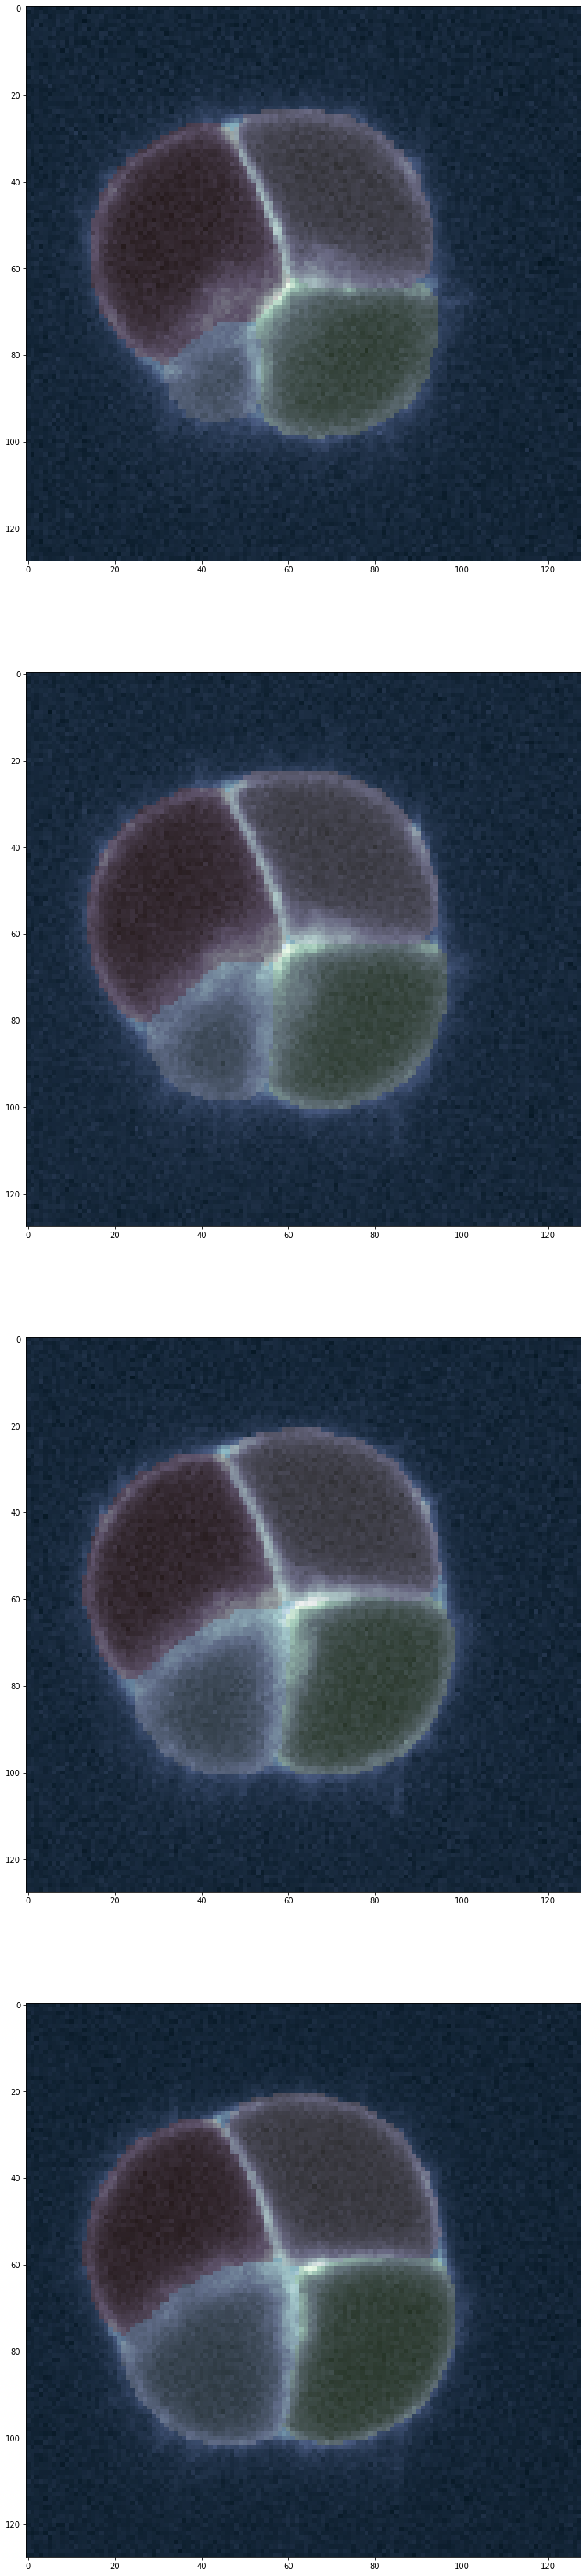

In [12]:
# Number of training sample to be visualized
sample_number = 0

# Set the first and the last slice to show. The default setting will visualize 8 middle slices.
slide_range = (12, 20)

sample_image = X[sample_number, slide_range[0]:slide_range[1], ...]
sample_mask = Y[sample_number, slide_range[0]:slide_range[1], ...]

nrows = int(np.ceil(math.sqrt(sample_image.shape[0])))
ncols = int(np.floor(math.sqrt(sample_image.shape[0])))

_, axes = plt.subplots(int(np.ceil(sample_image.shape[0] / 2)), 1, figsize=(30,60))
for i, ax in zip(range(sample_image.shape[0]), axes.flat):
    ax.imshow(sample_image[i, :, :], cmap='bone')
    ax.imshow(sample_mask[i, :, :], cmap='tab20', alpha=0.2)
plt.show()



## Visualize images/masks/borders
You can set the range to visualize all frames or some part

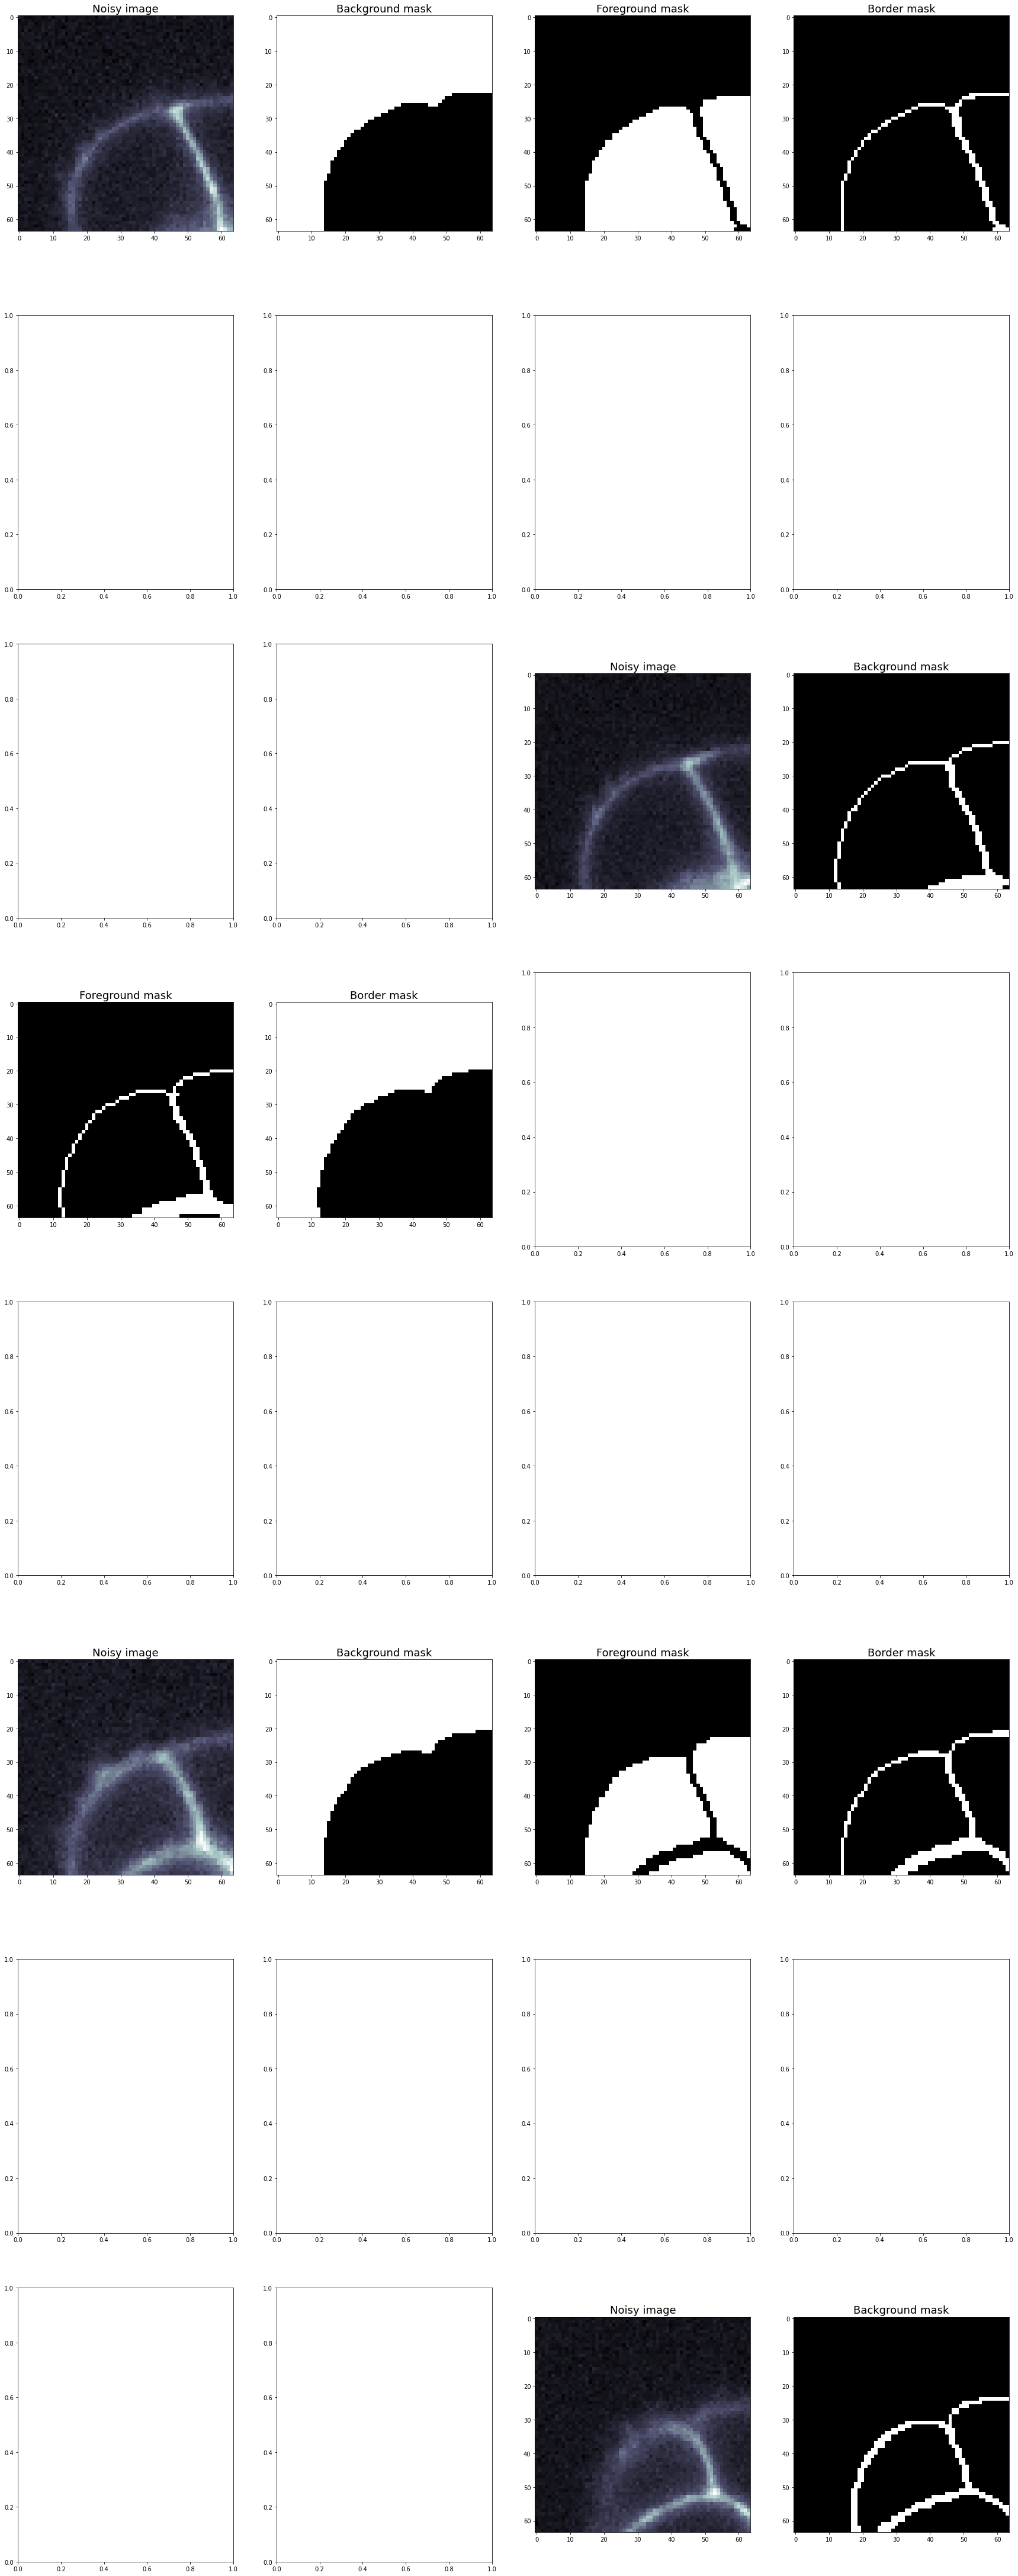

In [14]:
# Number of training sample to be visualized
sample_number = 0

# Set the first and the last slice to show. The default setting will visualize 8 middle slices.
slide_range = (12, 20)

aug_sample_image = X_final[sample_number, slide_range[0]:slide_range[1], ...]
aug_sample_mask = Y_final[sample_number, slide_range[0]:slide_range[1], ...]

# You may have to adjust figsize according to the number of slices
fig, axes = plt.subplots(aug_sample_image.shape[0], 4, figsize=(30,80))
for i, ax in zip(range(aug_sample_image.shape[0] * 4), axes.flat):
    if i % 10 == 0:
        ax.imshow(aug_sample_image[i // 4], cmap='bone')
        ax.set_title('Noisy image', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 10 == 1:
        ax.imshow(aug_sample_mask[i // 4, ..., (i % 4) - 1], cmap='bone')
        ax.set_title('Background mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 10 == 2:
        ax.imshow(aug_sample_mask[i // 4, ..., (i % 4) - 1], cmap='bone')
        ax.set_title('Foreground mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 10 == 3:
        ax.imshow(aug_sample_mask[i // 4, ..., (i % 4) - 1], cmap='bone')
        ax.set_title('Border mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
plt.show()

# Configure the model

In [ ]:
train_steps_per_epoch = min(400, max(int(X_final.shape[0]/train_batch_size), 10))

conf = DenoiSegConfig(X_final,
                      unet_kern_size=3,
                      n_channel_in=1,
                      n_channel_out=4,
                      relative_weights=[1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch,
                      train_epochs=20,
                      batch_norm=True,
                      train_batch_size=train_batch_size,
                      unet_n_first=32,
                      unet_n_depth=4,
                      denoiseg_alpha=0.5,
                      n2v_patch_shape=(32, 64, 64),
                      n2v_patch_size=(32, 64, 64),
                      train_tensorboard=False)

vars(conf)

In [ ]:
model = DenoiSeg(conf, model_name, basedir)

In [ ]:
history = model.train(X_final, Y_final, (X_val_final, Y_val_final))

In [ ]:
history.history.keys()

In [ ]:
plot_history(history, ['loss', 'val_loss'])

Computing Threshold Value
The network predicts 4 output channels:
The denoised input.
The foreground likelihoods.
The background likelihoods.
The border likelihoods.
We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [ ]:
threshold, val_score = model.optimize_thresholds(X_val.astype(np.float32),
                                                 Y_val,
                                                 measure=measure_precision(),
                                                 axes='ZYX'
                                                 )

print("The highest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

# Prediction
Because of limited number of samples in the dataset we do prediction on validation data .

In [ ]:
predicted_denoised, predicted_images, precision_result, predicted_binary = model.predict_denoised_label_masks(X_val.astype(np.float32),
                                                                                                              Y_val,
                                                                                                              axes='ZYX',
                                                                                                              threshold=threshold,
                                                                                                              measure=measure_precision()
                                                                                                             )
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

## Visualize denoised 3D volume
Here we resize the volume for visualization purposes, with regard to downsized Y and X


In [ ]:
original_3d = ndimage.zoom(X_val[0].squeeze(), (3.8468, 1, 1), order=0)
predicted_resized_3d = ndimage.zoom(predicted_denoised[0].squeeze(), (3.8468, 1, 1), order=0)
compare(original_3d, predicted_resized_3d)

## Visualize predicted masks in 3D

In [ ]:
gt_mask_3d = ndimage.zoom(Y_val[0].squeeze(), (3.8468, 1, 1), order=0)
predicted_mask_3d = ndimage.zoom(predicted_images[0].squeeze(), (3.8468, 1, 1), order=0)
compare(gt_mask_3d, predicted_mask_3d)

In [ ]:
sample_number = 1
slide_range = (12, 20)

original_image = X_val[sample_number, slide_range[0]:slide_range[1], ...]
predicted_denoised_image = predicted_denoised[sample_number][slide_range[0]:slide_range[1], ...]
predicted_mask = predicted_images[sample_number][slide_range[0]:slide_range[1], ...]
predicted_binary_mask = predicted_binary[sample_number][slide_range[0]:slide_range[1], ...]
gt_mask = Y_val[sample_number, slide_range[0]:slide_range[1], ...]


_, axes = plt.subplots(predicted_mask.shape[0], 5, figsize=(30,80))
for i, ax in zip(range(predicted_mask.shape[0] * 5), axes.flat):
    if i % 5 == 0:
        ax.imshow(original_image[i // 5], cmap='bone')
        ax.set_title('Original noisy Image', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 5 == 1:
        ax.imshow(predicted_denoised_image[i // 5], cmap='bone')
        ax.set_title('Denoised Image', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 5 == 2:
        ax.imshow(predicted_binary_mask[i // 5], cmap='bone')
        ax.set_title('Predicted_binary mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    elif i % 5 == 3:
        ax.imshow(predicted_mask[i // 5], cmap='tab20')
        ax.set_title('Predicted mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
    else:
        ax.imshow(gt_mask[i // 5, ...], cmap='tab20')
        ax.set_title('Ground truth mask', fontdict={'fontsize': 18, 'fontweight': 'medium'})
plt.show()